In [61]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
import pandas as pd

In [62]:
torch.manual_seed(51)

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [122]:
aaplStock = pd.read_csv('/content/drive/Shareddrives/Machine Learning /Dataset/AppleFinalData.csv')
msftStock = pd.read_csv('/content/drive/Shareddrives/Machine Learning /Dataset/MicrosoftFinalData.csv')

In [123]:
aaplOpenPrice = aaplStock["Open"].values
aaplClosePrice = aaplStock["Close"].values
msftOpenPrice = msftStock["Open"].values
msftClosePrice = msftStock["Close"].values
aaplSentiScore = aaplStock['compound']
msftSentiScore = msftStock['compound']

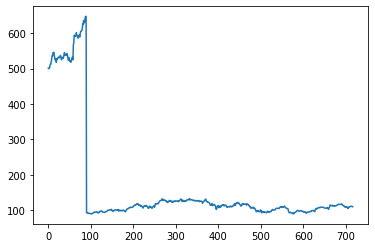

In [68]:
plt.plot(range(0, len(aaplClosePrice)), aaplClosePrice)

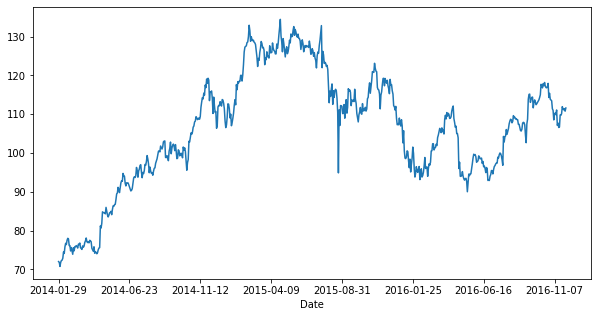

In [69]:
aaplStock.set_index("Date",drop=True,inplace=True)
aaplStock['Open'].plot(figsize=(10,5))

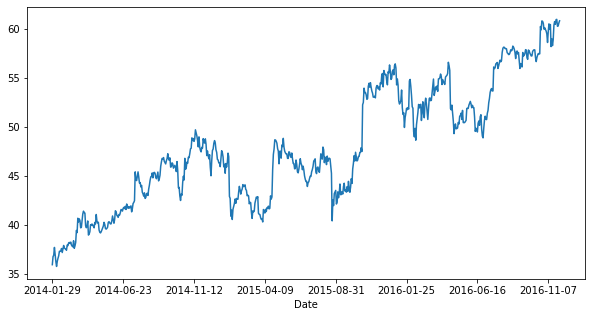

In [70]:
# Plotting MSFT stock data opening price
msftStock.set_index("Date",drop=True,inplace=True)
msftStock['Open'].plot(figsize=(10,5))

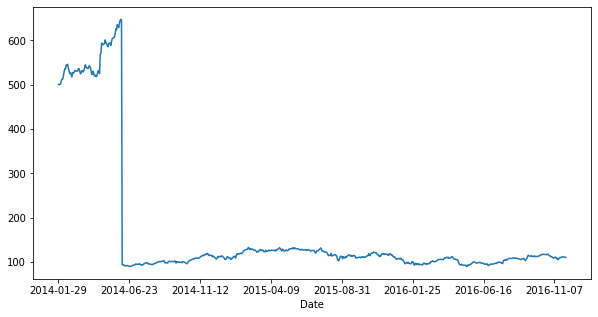

In [71]:
# aaplStock.set_index("Date",drop=True,inplace=True)
aaplStock['Close'].plot(figsize=(10,5))

# Correcting Apple stock

In [72]:
# To account for the 1:7 stock split in June 2014, divide all stocks data before the date by 7 to normalize it
# aaplOpenPrice[:1890] /= 7
# aaplClosePrice[:1890] /= 7
aaplStock['Close'].loc[:'2014-06-09'].iloc[:-1] /= 7


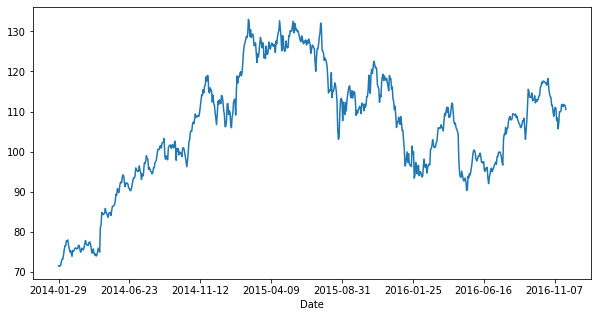

In [73]:
# Plotting AAPL stock opening price data after correction for stock split
aaplStock['Close'].plot(figsize=(10,5))

In [74]:
# Checking the sentiment score for AAPL
aaplSentiScore

1800    0.0000
1801   -0.3102
1802    0.8083
1803    0.0000
1804    0.4999
         ...  
2512    0.0000
2513   -0.8990
2514    0.0000
2515    0.0000
2516    0.0000
Name: compound, Length: 717, dtype: float64

# Detrending data to remove general upwards trend using scipy
The stock data has a general upward trend. We need to remove this trend or else the model will just buy initially and hold until the final timestep without selling. Also, this is not consistent in degree between AAPL and MSFT stocks. In order to feed both the data to the model, we need to normalize them and in order to do so, we detrend the data first to get them to a normalized plane. 

In [75]:
from scipy import signal

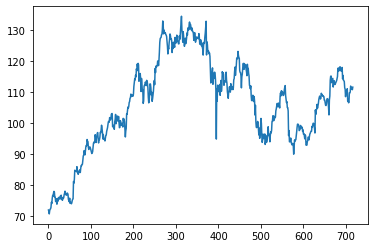

In [76]:
#Before detrend
plt.plot(range(0,len(aaplOpenPrice)), aaplStock['Open'])

In [77]:
aaplOpenPrice = signal.detrend(aaplOpenPrice)
aaplClosePrice = signal.detrend(aaplClosePrice)

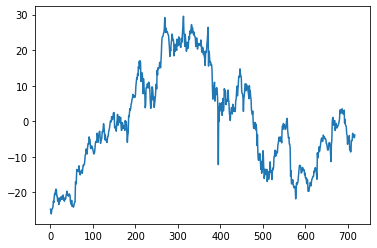

In [78]:
#After detrend
plt.plot(range(0,len(aaplOpenPrice)), aaplOpenPrice)

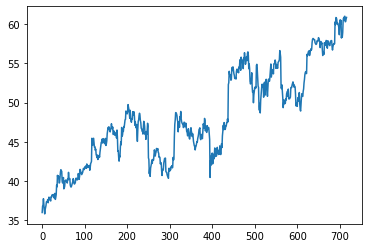

In [79]:
#Before detrend our data
plt.plot(range(0,len(msftOpenPrice)), msftStock['Open'])

In [80]:
msftOpenPrice = signal.detrend(msftOpenPrice)
msftClosePrice = signal.detrend(msftClosePrice)

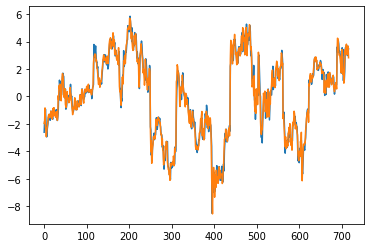

In [81]:
#After detrend
plt.plot(range(0,len(msftOpenPrice)), msftOpenPrice)
plt.plot(range(0,len(msftClosePrice)), msftClosePrice)

# Remove negative values

In [82]:
print(aaplOpenPrice.min())
print(aaplClosePrice.min())
print(msftOpenPrice.min())
print(msftClosePrice.min())

-26.047000294097955
-25.342359100992553
-8.5147482283124
-8.560893534836381


In [83]:
# choosing 30 as a starting point 
add_value = 30.
aaplOpenPrice += add_value
aaplClosePrice += add_value
msftOpenPrice += add_value
msftClosePrice += add_value

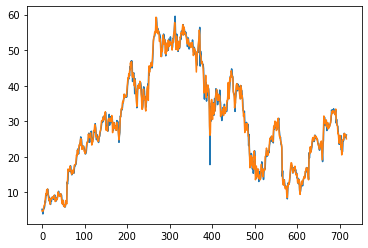

In [84]:
# After removing negative values, aapl stock looks this way
plt.plot(range(0,len(aaplOpenPrice)), aaplOpenPrice)
plt.plot(range(0,len(aaplClosePrice)), aaplClosePrice)

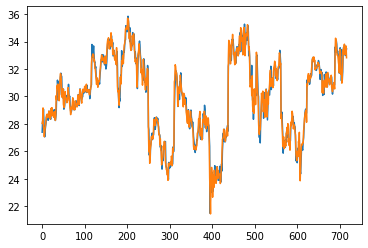

In [85]:
# After removing negative values, msft stock looks this way
plt.plot(range(0,len(msftOpenPrice)), msftOpenPrice)
plt.plot(range(0,len(msftClosePrice)), msftClosePrice)

In [86]:
aaplStock.reset_index(drop=True,inplace=True)
msftStock.reset_index(drop=True,inplace=True)

In [87]:
aaplSentiScore=aaplStock['compound']
msftSentiScore=msftStock['compound']

# Building the environment

In [88]:
import sys
import math

* We assign an initialCash to start off the run and we can assign variance to each run by assigning a std deviation to the initial cash (here stdDev is set to 0 to get predictability in initial cash between different runs) 
* The action space  is as follows: 
0 - buy AAPL, 1 - sell AAPL, 2 - do nothing, 3 - buy MSFT, 4 - sell MSFT
* Observation space: AAPL shares, MSFT shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], Running 5 day average [6apl, 7msf] = 8


# Trading Environment without Sentiment Score

In [89]:
class TradingEnvironment():
#(maxStride=4, seriesLength=250, meanInitialCash=1000, stdDevInitialCash=100, meanInitialShares=100, stdDevInitialShares=10)
    def __init__(self, meanInitialCash=500., maxStride=2, seriesLength=208, startPoint=1, stdDevInitialCash=0, 
                 meanInitialShares=0., stdDevInitialShares=0., inactionPenalty=0.):
        self.meanInitialShares = meanInitialShares
        self.stdDevInitialShares = stdDevInitialShares
        self.meanInitialCash = meanInitialCash
        self.stdDevInitialCash = stdDevInitialCash
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.seriesLength = seriesLength
        self.startPoint = startPoint
        self.currentTimestep = self.startPoint

        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]
        
        self.maxStride = maxStride
        self.stride = self.maxStride # no longer varying it
        
        self.done = False
        self.divBonus = 1.
        self.inactionPenalty = inactionPenalty
    
    def portfolioVal(self):
        return (self.state[0] * aaplClosePrice[self.currentTimestep]) + (self.state[1] * msftClosePrice[self.currentTimestep]) + self.state[2]
    
    def nextOpenPrice(self):
        step = self.currentTimestep + self.stride
        return [aaplOpenPrice[step], msftOpenPrice[step]]
    
    def runningFiveAverage(self):
        step = self.currentTimestep
        if step < 5:
            return [aaplOpenPrice[0], msftOpenPrice[0]]
        apl5 = aaplOpenPrice[step-5:step].mean() #aaplOpenPrice[3:8].mean() ->if step is 8
        msf5 = msftOpenPrice[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        currentTimestep = self.currentTimestep
        timestepsLeft= self.seriesLength - (currentTimestep - self.startPoint) # 208 - (1-1)
        retval = None
        currentVal = self.portfolioVal()
        gain = currentVal - self.initialPortfolioVal
        if currentTimestep >= self.startPoint + (self.seriesLength * self.stride):
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
            self.state = newState
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.divBonus
            return newState, currentVal + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                    currentVal, *self.runningFiveAverage()]
            self.state = newState
            retval = newState, -self.inactionPenalty-timestepsLeft +gain, False, { "msg": "No Action" }
            
        if action[0] == 0:
            if action[1] * aaplOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                aaplShareCount = self.state[0] + action[1]
                cashSpent = action[1] * aaplOpenPrice[currentTimestep] * 1.1
                newState = [aaplShareCount, self.state[1], self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore*gainModificationScore), False, { "msg": "Bought AAPL"}

        if action[0] == 3:
            if action[1] * msftOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval =  newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                msftShareCount = self.state[1] + action[1]
                cashSpent = action[1] * msftOpenPrice[currentTimestep] * 1.1
                newState = [self.state[0], msftShareCount, self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:# 1> 90
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                aaplShareCount = self.state[0] - action[1]
                cashGained = action[1] * aaplOpenPrice[currentTimestep] * 0.9
                newState = [aaplShareCount, self.state[1], self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                msftShareCount = self.state[1] - action[1]
                cashGained = action[1] * msftOpenPrice[currentTimestep] * 0.9
                newState = [self.state[0], msftShareCount, self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold MSFT"}
                
        self.currentTimestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.currentTimestep = self.startPoint
        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]       
        self.done = False
        return self.state

# Trading Environment with minimal Sentiment score

In [90]:
class TradingEnvironment():
#(maxStride=4, seriesLength=250, meanInitialCash=1000, stdDevInitialCash=100, meanInitialShares=100, stdDevInitialShares=10)
    def __init__(self, meanInitialCash=500., maxStride=2, seriesLength=208, startPoint=1, stdDevInitialCash=0, 
                 meanInitialShares=0., stdDevInitialShares=0., inactionPenalty=0.):
        self.meanInitialShares = meanInitialShares
        self.stdDevInitialShares = stdDevInitialShares
        self.meanInitialCash = meanInitialCash
        self.stdDevInitialCash = stdDevInitialCash
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.seriesLength = seriesLength
        self.startPoint = startPoint
        self.currentTimestep = self.startPoint

        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]
        
        self.maxStride = maxStride
        self.stride = self.maxStride # no longer varying it
        
        self.done = False
        self.divBonus = 1.
        self.inactionPenalty = inactionPenalty
    
    def portfolioVal(self):
        return (self.state[0] * aaplClosePrice[self.currentTimestep]) + (self.state[1] * msftClosePrice[self.currentTimestep]) + self.state[2]
    
    def nextOpenPrice(self):
        step = self.currentTimestep + self.stride
        return [aaplOpenPrice[step], msftOpenPrice[step]]
    
    def runningFiveAverage(self):
        step = self.currentTimestep
        if step < 5:
            return [aaplOpenPrice[0], msftOpenPrice[0]]
        apl5 = aaplOpenPrice[step-5:step].mean() #aaplOpenPrice[3:8].mean() ->if step is 8
        msf5 = msftOpenPrice[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        currentTimestep = self.currentTimestep
        timestepsLeft= self.seriesLength - (currentTimestep - self.startPoint) # 208 - (1-1)
        retval = None
        currentVal = self.portfolioVal()
        gain = currentVal - self.initialPortfolioVal
        if currentTimestep >= self.startPoint + (self.seriesLength * self.stride):
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
            self.state = newState
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.divBonus
            return newState, currentVal + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                    currentVal, *self.runningFiveAverage()]
            self.state = newState
            retval = newState, -self.inactionPenalty-timestepsLeft +gain, False, { "msg": "No Action" }
            
        if action[0] == 0:
            if action[1] * aaplOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                aaplShareCount = self.state[0] + action[1]
                cashSpent = action[1] * aaplOpenPrice[currentTimestep] * 1.1
                newState = [aaplShareCount, self.state[1], self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(aaplSentiScore[currentTimestep]<=-0.05):
                  gainModificationScore = -1*aaplSentiScore[currentTimestep]*aaplSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Bought AAPL"}

        if action[0] == 3:
            if action[1] * msftOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval =  newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                msftShareCount = self.state[1] + action[1]
                cashSpent = action[1] * msftOpenPrice[currentTimestep] * 1.1
                newState = [self.state[0], msftShareCount, self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(msftSentiScore[currentTimestep]<=-0.05):
                  gainModificationScore = -1*msftSentiScore[currentTimestep]*msftSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:# 1> 90
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                aaplShareCount = self.state[0] - action[1]
                cashGained = action[1] * aaplOpenPrice[currentTimestep] * 0.9
                newState = [aaplShareCount, self.state[1], self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(aaplSentiScore[currentTimestep]>=0.05):
                  gainModificationScore = aaplSentiScore[currentTimestep]*aaplSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                msftShareCount = self.state[1] - action[1]
                cashGained = action[1] * msftOpenPrice[currentTimestep] * 0.9
                newState = [self.state[0], msftShareCount, self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(msftSentiScore[currentTimestep]>=0.05):
                  gainModificationScore = msftSentiScore[currentTimestep]*msftSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold MSFT"}
                
        self.currentTimestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.currentTimestep = self.startPoint
        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]       
        self.done = False
        return self.state

# Trading Environment with nominal Sentiment score

In [91]:
class TradingEnvironment():
#(maxStride=4, seriesLength=250, meanInitialCash=1000, stdDevInitialCash=100, meanInitialShares=100, stdDevInitialShares=10)
    def __init__(self, meanInitialCash=500., maxStride=2, seriesLength=208, startPoint=1, stdDevInitialCash=0, 
                 meanInitialShares=0., stdDevInitialShares=0., inactionPenalty=0.):
        self.meanInitialShares = meanInitialShares
        self.stdDevInitialShares = stdDevInitialShares
        self.meanInitialCash = meanInitialCash
        self.stdDevInitialCash = stdDevInitialCash
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.seriesLength = seriesLength
        self.startPoint = startPoint
        self.currentTimestep = self.startPoint

        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]
        
        self.maxStride = maxStride
        self.stride = self.maxStride # no longer varying it
        
        self.done = False
        self.divBonus = 1.
        self.inactionPenalty = inactionPenalty
    
    def portfolioVal(self):
        return (self.state[0] * aaplClosePrice[self.currentTimestep]) + (self.state[1] * msftClosePrice[self.currentTimestep]) + self.state[2]
    
    def nextOpenPrice(self):
        step = self.currentTimestep + self.stride
        return [aaplOpenPrice[step], msftOpenPrice[step]]
    
    def runningFiveAverage(self):
        step = self.currentTimestep
        if step < 5:
            return [aaplOpenPrice[0], msftOpenPrice[0]]
        apl5 = aaplOpenPrice[step-5:step].mean() #aaplOpenPrice[3:8].mean() ->if step is 8
        msf5 = msftOpenPrice[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        currentTimestep = self.currentTimestep
        timestepsLeft= self.seriesLength - (currentTimestep - self.startPoint) # 208 - (1-1)
        retval = None
        currentVal = self.portfolioVal()
        gain = currentVal - self.initialPortfolioVal
        if currentTimestep >= self.startPoint + (self.seriesLength * self.stride):
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
            self.state = newState
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.divBonus
            return newState, currentVal + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                    currentVal, *self.runningFiveAverage()]
            self.state = newState
            retval = newState, -self.inactionPenalty-timestepsLeft +gain, False, { "msg": "No Action" }
            
        if action[0] == 0:
            if action[1] * aaplOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                aaplShareCount = self.state[0] + action[1]
                cashSpent = action[1] * aaplOpenPrice[currentTimestep] * 1.1
                newState = [aaplShareCount, self.state[1], self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(aaplSentiScore[currentTimestep]<=-0.05):
                  gainModificationScore = aaplSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Bought AAPL"}

        if action[0] == 3:
            if action[1] * msftOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval =  newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                msftShareCount = self.state[1] + action[1]
                cashSpent = action[1] * msftOpenPrice[currentTimestep] * 1.1
                newState = [self.state[0], msftShareCount, self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(msftSentiScore[currentTimestep]<=-0.05):
                  gainModificationScore = msftSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:# 1> 90
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                aaplShareCount = self.state[0] - action[1]
                cashGained = action[1] * aaplOpenPrice[currentTimestep] * 0.9
                newState = [aaplShareCount, self.state[1], self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(aaplSentiScore[currentTimestep]>=0.05):
                  gainModificationScore = aaplSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                msftShareCount = self.state[1] - action[1]
                cashGained = action[1] * msftOpenPrice[currentTimestep] * 0.9
                newState = [self.state[0], msftShareCount, self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(msftSentiScore[currentTimestep]>=0.05):
                  gainModificationScore = msftSentiScore[currentTimestep]
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold MSFT"}
                
        self.currentTimestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.currentTimestep = self.startPoint
        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]       
        self.done = False
        return self.state

# Trading Environment with high Sentiment score

In [101]:
class TradingEnvironment():
#(maxStride=4, seriesLength=250, meanInitialCash=1000, stdDevInitialCash=100, meanInitialShares=100, stdDevInitialShares=10)
    def __init__(self, meanInitialCash=500., maxStride=2, seriesLength=208, startPoint=1, stdDevInitialCash=0, 
                 meanInitialShares=0., stdDevInitialShares=0., inactionPenalty=0.):
        self.meanInitialShares = meanInitialShares
        self.stdDevInitialShares = stdDevInitialShares
        self.meanInitialCash = meanInitialCash
        self.stdDevInitialCash = stdDevInitialCash
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.seriesLength = seriesLength
        self.startPoint = startPoint
        self.currentTimestep = self.startPoint

        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]
        
        self.maxStride = maxStride
        self.stride = self.maxStride # no longer varying it
        
        self.done = False
        self.divBonus = 1.
        self.inactionPenalty = inactionPenalty
    
    def portfolioVal(self):
        return (self.state[0] * aaplClosePrice[self.currentTimestep]) + (self.state[1] * msftClosePrice[self.currentTimestep]) + self.state[2]
    
    def nextOpenPrice(self):
        step = self.currentTimestep + self.stride
        return [aaplOpenPrice[step], msftOpenPrice[step]]
    
    def runningFiveAverage(self):
        step = self.currentTimestep
        if step < 5:
            return [aaplOpenPrice[0], msftOpenPrice[0]]
        apl5 = aaplOpenPrice[step-5:step].mean() #aaplOpenPrice[3:8].mean() ->if step is 8
        msf5 = msftOpenPrice[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        currentTimestep = self.currentTimestep
        timestepsLeft= self.seriesLength - (currentTimestep - self.startPoint) # 208 - (1-1)
        retval = None
        currentVal = self.portfolioVal()
        gain = currentVal - self.initialPortfolioVal
        if currentTimestep >= self.startPoint + (self.seriesLength * self.stride):
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
            self.state = newState
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.divBonus
            return newState, currentVal + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                    currentVal, *self.runningFiveAverage()]
            self.state = newState
            retval = newState, -self.inactionPenalty-timestepsLeft +gain, False, { "msg": "No Action" }
            
        if action[0] == 0:
            if action[1] * aaplOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                aaplShareCount = self.state[0] + action[1]
                cashSpent = action[1] * aaplOpenPrice[currentTimestep] * 1.1
                newState = [aaplShareCount, self.state[1], self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(aaplSentiScore[currentTimestep]<=-0.05):
                  gainModificationScore = -1*math.sqrt(aaplSentiScore[currentTimestep]*aaplSentiScore[currentTimestep])
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore*gainModificationScore), False, { "msg": "Bought AAPL"}

        if action[0] == 3:
            if action[1] * msftOpenPrice[currentTimestep] > self.state[2]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval =  newState, -timestepsLeft+gain/2, True, { "msg": "Action ended in bankruptcy"}
            else:
                msftShareCount = self.state[1] + action[1]
                cashSpent = action[1] * msftOpenPrice[currentTimestep] * 1.1
                newState = [self.state[0], msftShareCount, self.state[2] - cashSpent, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(msftSentiScore[currentTimestep]<=-0.05):
                  gainModificationScore = -1*math.sqrt(msftSentiScore[currentTimestep]*msftSentiScore[currentTimestep])
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:# 1> 90
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                aaplShareCount = self.state[0] - action[1]
                cashGained = action[1] * aaplOpenPrice[currentTimestep] * 0.9
                newState = [aaplShareCount, self.state[1], self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(aaplSentiScore[currentTimestep]>=0.05):
                  gainModificationScore = math.sqrt(aaplSentiScore[currentTimestep]*aaplSentiScore[currentTimestep])
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                newState = [self.state[0], self.state[1], self.state[2], *self.nextOpenPrice(), \
                        currentVal, *self.runningFiveAverage()]
                self.state = newState
                retval = newState, -timestepsLeft+gain/2, True, { "msg": "Sold more than number of shares in portfolio"}
            else:
                msftShareCount = self.state[1] - action[1]
                cashGained = action[1] * msftOpenPrice[currentTimestep] * 0.9
                newState = [self.state[0], msftShareCount, self.state[2] + cashGained, *self.nextOpenPrice(), \
                       currentVal, *self.runningFiveAverage()]
                self.state = newState
                gainModificationScore = 0
                if(msftSentiScore[currentTimestep]>=0.05):
                  gainModificationScore = math.sqrt(msftSentiScore[currentTimestep]*msftSentiScore[currentTimestep])
                retval = newState, self.inactionPenalty-timestepsLeft+gain*(1+gainModificationScore), False, { "msg": "Sold MSFT"}
                
        self.currentTimestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.initialCash = max(int(np.random.normal(self.meanInitialCash, self.stdDevInitialCash)), 0.)
        self.currentTimestep = self.startPoint
        self.state[0] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[1] = max(int(np.random.normal(self.meanInitialShares, self.stdDevInitialShares)), 0.)
        self.state[2] = self.initialCash
        self.state[3] = aaplOpenPrice[self.currentTimestep]
        self.state[4] = msftOpenPrice[self.currentTimestep]
        self.initialPortfolioVal = self.portfolioVal()
        self.state[5] = self.initialPortfolioVal
        self.state[6] = self.runningFiveAverage()[0]
        self.state[7] = self.runningFiveAverage()[1]       
        self.done = False
        return self.state

# Policy

In [102]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32),dtype=torch.float).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.actionHead = nn.Linear(31, 5)
        self.valHead = nn.Linear(31, 1)
        self.savedActions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32),dtype=torch.float).cuda()
        
    def forward(self, x):
        x = torch.tensor(x,dtype=torch.float).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        actionScore = self.actionHead(x)
        stateVal = self.valHead(x)
        return F.softmax(actionScore, dim=-1), stateVal
    
    def act(self, state):
        
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1:
          action = torch.LongTensor([2]).squeeze().cuda()
          print(action)
        if action == 4 and env.state[1] < 1:
          action = torch.LongTensor([2]).squeeze().cuda()
          print(action)
        self.savedActions.append((m.log_prob(action), state_value))
        return action.item()

# Creating a sample environment

In [109]:
env = TradingEnvironment(maxStride=2, seriesLength=100, meanInitialCash=1000, stdDevInitialCash=0, meanInitialShares=100, stdDevInitialShares=0)
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [110]:
env.reset()
del model.rewards[:]
del model.savedActions[:]

In [111]:
def finish_episode():
    R = 0
    savedActions = model.savedActions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards,dtype=torch.float)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    rewards += epsilon
    
    for (log_prob, value), r in zip(savedActions, rewards):
        reward = torch.tensor(r - value.item(),dtype=torch.float).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r],dtype=torch.float).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.savedActions[:]


## Running for 600 episodes

In [112]:
gamma = 0.9
log_interval = 30
runningReward = 0
for episode in range(0, 600):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    runningReward = runningReward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()

    if msg["msg"] == "done" and env.portfolioVal() > env.initialPortfolioVal * 1.1 and runningReward > 500:
        print("Early finish: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: starting value : {:.1f}, finishing value : {:.1f} : {} @ t={}, \
    Last reward {:.1f}, Running reward {:.1f}""".format(episode, env.initialPortfolioVal, \
              env.portfolioVal(), msg["msg"], env.currentTimestep, reward, runningReward))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Episode 0: starting value : 4286.7, finishing value : 8444.9 : done @ t=201,     Last reward 12604.2, Running reward 420.1
Early finish: 12517


## Iterating over 50 runs

In [115]:
env = TradingEnvironment(maxStride=2, seriesLength=208, meanInitialCash=1000, stdDevInitialCash=0, meanInitialShares=100, stdDevInitialShares=0)
totalRewards = 0
totalProfits = 0
failedRuns = 0
numRuns = 50

print("Starting Portfolio value : {}".format(env.initialPortfolioVal))
for j in range(numRuns):
    env.reset()
    runReward = -1e8
    for i in range(0,env.seriesLength + 1): 
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            runReward = env.portfolioVal()
            break
        if done:
            break
    totalProfits += (env.portfolioVal() - env.initialPortfolioVal) / env.initialPortfolioVal
    if runReward == -1e8:
        failedRuns += 1
    else:
        totalRewards += runReward

if failedRuns == numRuns:
    print("Failed all")
else:
    print("Failed runs: {} / {}, Avg Rewards per successful game: {}".format(failedRuns, numRuns, totalRewards / (numRuns - failedRuns)))
    print("Avg % profit per game: {}".format(totalProfits / numRuns*100))
    print("Avg % profit per finished game: {}".format(totalProfits / (numRuns - failedRuns)*100))

Starting Portfolio value : 4286.69970703125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Failed runs: 4 / 50, Avg Rewards per successful game: 6574.7509765625
Avg % profit per game: 56.50284957885742
Avg % profit per finished game: 61.416141510009766



# Store results 50 runs from one colab runtime (since the output varies with each runtime)

**Without Sentiment Score**

Failed goes: 42 / 50, Avg Rewards per successful game: 6699.35302734375

Avg Rewards per game (including failed games): 1071.896484375

Avg % profit per game: 89.80928659439087

Avg % profit per finished game: 561.30805015563965

**With High Sentiment Score**

Failed goes: 5 / 50, Avg Rewards per successful game: 6710.8701171875

Avg Rewards per game (including failed games): 6039.783203125

Avg % profit per game: 61.20380163192749

Avg % profit per finished game: 68.00422668457031

**With Normal Sentiment Score**

Failed goes: 7 / 50, Avg Rewards per successful game: 6754.5654296875

Avg Rewards per game (including failed games): 5808.92626953125

Avg % profit per game: 61.01148724555969

Avg % profit per finished game: 70.94359397888184

**With Low Sentiment Score**

Failed goes: 16 / 50, Avg Rewards per successful game: 6682.72265625

Avg Rewards per game (including failed games): 4544.2509765625

Avg % profit per game: 65.99946618080139

Avg % profit per finished game: 97.05803990364075




In [57]:
# Noting the results from one run since the output varies a little bit each run
failedRuns = [42,16,7,5]
avgReward = [1071, 4544, 5808, 6039]
avgProfit = [89.8, 65.99, 61.01, 61.20]
xaxis = ['NoSentiment','minSentiment','avgSentiment','highSentiment']



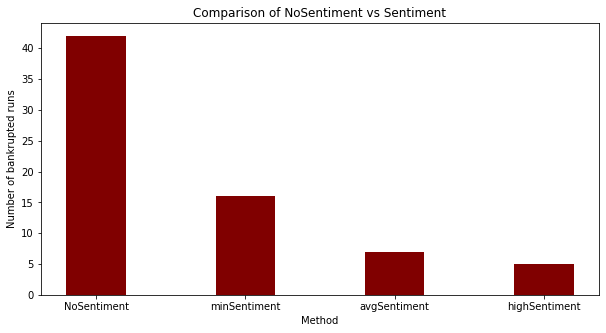

In [58]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(xaxis, failedRuns, color ='maroon',
        width = 0.4)
plt.xlabel("Method")
plt.ylabel("Number of bankrupted runs")
plt.title("Comparison of NoSentiment vs Sentiment")
plt.show()

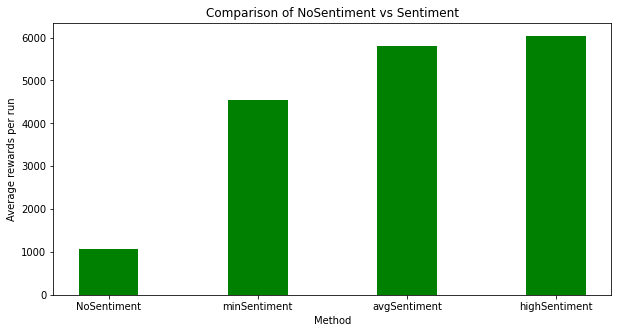

In [59]:
# creating the dataset
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(xaxis, avgReward, color ='green',
        width = 0.4)
plt.xlabel("Method")
plt.ylabel("Average rewards per run")
plt.title("Comparison of NoSentiment vs Sentiment")
plt.show()

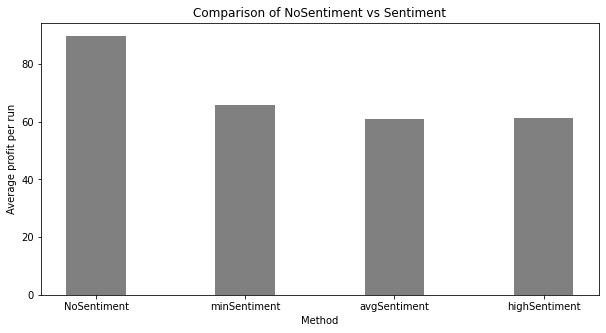

In [60]:
# creating the dataset
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(xaxis, avgProfit, color ='grey',
        width = 0.4)
plt.xlabel("Method")
plt.ylabel("Average profit per run")
plt.title("Comparison of NoSentiment vs Sentiment")
plt.show()